## Experiment Setup for running iPerf3

1. The server and client are two bare metals of the same model. (2 CPU sockets totally accommodate 24 physical cores and 24 virtual cores)
![screenshot](https://raw.githubusercontent.com/ljishen/eucycles/master/analysis/images/node_configuration.png)

2. The server and client are connecting via a VLAN with MTU of 1500 bytes, which is configured to be **isolated** at network layer 2 (Data link). See [OSI_model](https://en.wikipedia.org/wiki/OSI_model).
   - https://www.chameleoncloud.org/docs/bare-metal-user-guide/network-isolation-bare-metal/
   - http://chameleoncloud.readthedocs.io/en/latest/technical/networks.html

3. The tests use TCP protocol. The server reads the data from file and write it to the network. The client receives the data and throws the data right away.

4. Each test drops the file cache using the following command on the server
   ```bash
   sync; echo 3 > /proc/sys/vm/drop_caches
   ```

5. The client establishes only one connection (single stream) to the server in one thread. (Related [issue](https://github.com/esnet/iperf/issues/289) about the single-threaded design of iperf3)

6. The client sets CPU affinity to just one core.

7. No CPU, memory or disk I/O utilization bottleneck on either the client or the server during the tests.

8. The connection on the client has TCP maximum segment size (MSS): 1448 by default.

9. Congestion algorithm is cubic on both client and server.

10. TCP segment retransmission rate < 0.0000514%

11. (?) It is interesting to also see how jumbo frame could reduce the CPU usage.

In [1]:
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def show_chart(benchmark):
    FILE_PATH = '../playbooks/remote_read_' + benchmark + '/output/result.csv'
    HEADER_COL = [0 ,1]

    with open(FILE_PATH, 'r') as f:
        num_rows = f.readline().count(',')
    df = pd.read_csv(FILE_PATH, index_col=HEADER_COL, header=None, names=range(1, num_rows)).T


    # Add the avrerage row and the standard deviation row 
    ROW_NAME_AVG = 'AVG'
    ROW_NAME_STD = 'STD'
    df = df.rename({num_rows - 1: ROW_NAME_AVG})
    df.loc[ROW_NAME_STD] = np.nan

    num_data_raws = num_rows - len(HEADER_COL)
    for category in df.columns:
        df[category][ROW_NAME_AVG] = np.mean(df[category][:num_data_raws])
        df[category][ROW_NAME_STD] = np.std(df[category][:num_data_raws], ddof=1)

    display(HTML(df.to_html()))


    # Start to draw the chart

    N = len(df.columns) / 2
    ind = np.arange(N)  # the x locations for the groups

    # Draw bins for Cycles
    fig, ax1 = plt.subplots()
    clr = 'r'
    cycle_bar = ax1.bar(ind, df.loc[ROW_NAME_AVG][0::2], width=0.35, color=clr, yerr=df.loc[ROW_NAME_STD][0::2])
    ax1.set_yscale('log')
    # ax1.set_ylim(ymin=1e7)
    ax1.set_ylabel(df.columns[0][1], color=clr)
    ax1.tick_params('y', colors=clr)


    # Draw lines for Bitrate
    ax2 = ax1.twinx()
    clr = 'b'
    bitrate_bar = ax2.errorbar(ind, df.loc[ROW_NAME_AVG][1::2], color=clr, yerr=df.loc[ROW_NAME_STD][1::2], fmt='-o')
    # ax2.set_ylim(ymin=1e7)
    ax2.set_ylabel(df.columns[1][1] + ' (bit/s)', color=clr)
    ax2.tick_params('y', colors=clr)

    # Change the size of figure
    # See https://stackoverflow.com/a/4306340
    fig.set_dpi(120)

    ax1.set_xlabel('Transmission Size (Bytes)')
    labels = [h[0] for h in df.columns][0::2]
    plt.xticks(ind, labels)
    plt.legend([cycle_bar, bitrate_bar], df[df.columns[0][0]].columns)
    plt.title('CPU Cycles and Network Bandwidth on Receiver under Different Transmission Size (' + benchmark + ')', y=1.1)
    
    plt.savefig('charts/remote_read_cycles_' + benchmark + '.png', bbox_inches='tight')
    plt.show()

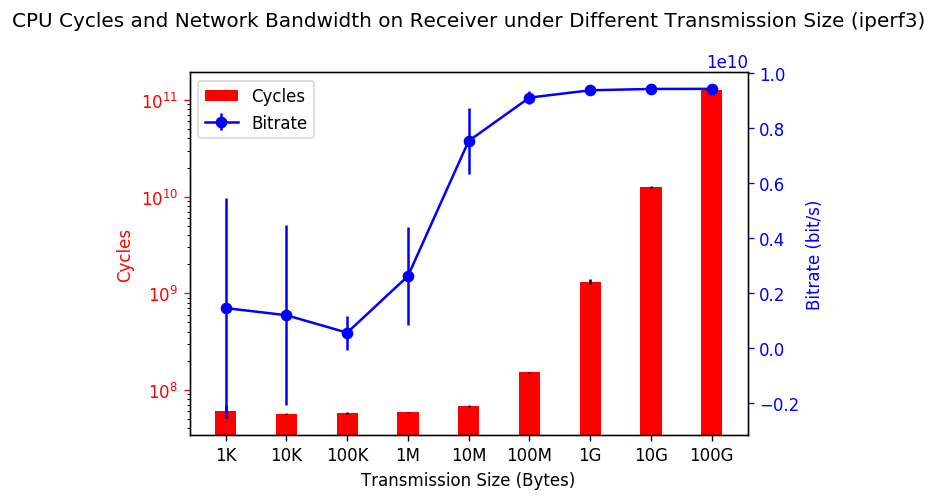

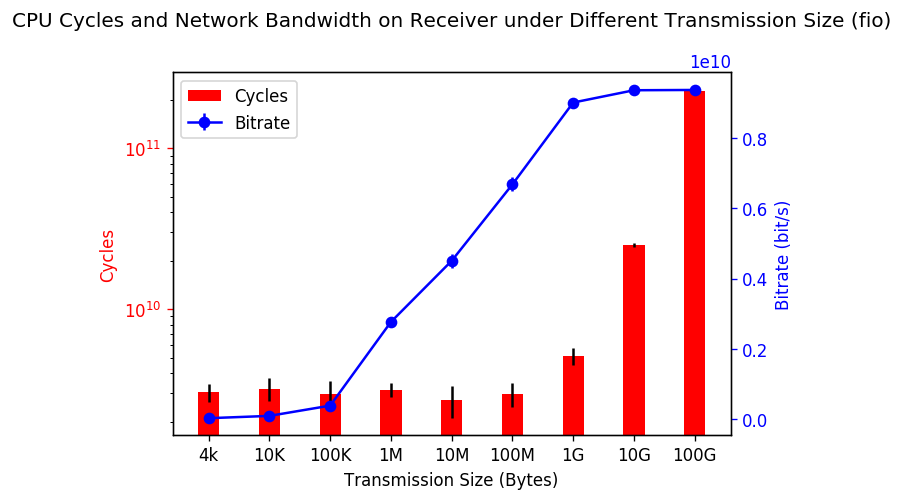

In [3]:
show_chart('iperf3')
show_chart('fio')